In [99]:
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import numpy as np
import talib as ta

In [100]:
activo = 'ETH-USD'
df = yf.Ticker(activo)
df = df.history(start='2022-01-01', end='2024-11-20')

In [101]:
# Cálculo del MACD
df['MACD'], df['Signal_line'], df['Histogram'] = ta.MACD(df['Close'], fastperiod=12,
                                                         slowperiod=26, signalperiod=9)

In [102]:
# Cálculo SMA200
df['SMA200'] = ta.SMA(df['Close'], timeperiod=200)

In [103]:
# Crear columna para señales
df['Signal'] = 0

# Señal de compra: tendencia alcista y MACD por encima de la señal
df.loc[(df['MACD'] > df['Signal_line']), 'Signal'] = 1

# Señal de venta: tendencia bajista y MACD por debajo de la señal
df.loc[(df['MACD'] < df['Signal_line']), 'Signal'] = -1


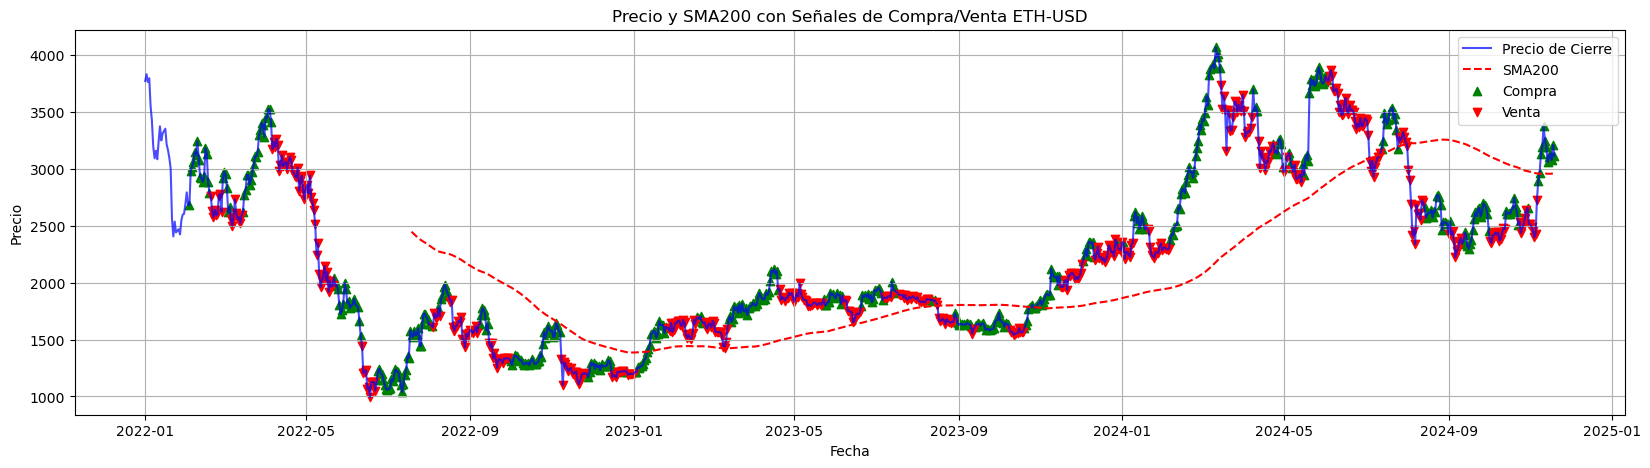

In [108]:
# Gráfico
plt.figure(figsize=(20,5))

plt.plot(df.index, df['Close'], label = 'Precio de Cierre', color='blue', alpha=0.7)
plt.plot(df.index, df['SMA200'], label='SMA200', color='red', linestyle='--')
plt.scatter(df.index[df['Signal'] == 1], df['Close'][df['Signal'] == 1], marker='^', color='green', label='Compra', alpha=1)
plt.scatter(df.index[df['Signal'] == -1], df['Close'][df['Signal'] == -1], marker='v', color='red', label='Venta', alpha=1)

plt.title(f'Precio y SMA200 con Señales de Compra/Venta {activo}')
plt.xlabel('Fecha')
plt.ylabel('Precio')
plt.legend()
plt.grid()
